<a href="https://colab.research.google.com/github/deeptanshukumar/B-PLIS-rag/blob/main/bplis_basics_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ContextFocus Dynamic: Budgeted Per-Query Latent Intervention Search

This notebook implements **ContextFocus Dynamic steering** for resolving context–memory conflicts in RAG systems.

**Paper**: "Budgeted Per-Query Latent Intervention Search to Resolve Context–Memory Conflicts in RAG"

## 📋 Overview

This implementation includes:
- **Steering vector construction** using contrastive activations
- **Static layer selection** to find the optimal layer
- **Dynamic per-query layer selection** for improved performance
- **ConFiQA evaluation** on QA, MR, and MC subsets
- **Visualization** and interactive demos

## 🚀 Usage

1. Run cells sequentially
2. Upload ConFiQA JSON files when prompted (Cell 15)
3. Results will be displayed with charts

**Hardware**: Requires GPU (T4 or better recommended)


In [ ]:
# Cell 0 — Environment Setup & Installation

!pip install -q transformers accelerate datasets torch tqdm sentencepiece

import torch
import numpy as np
import random
import json
import re
import string
from pathlib import Path
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence, Tuple, Iterable
from tqdm import tqdm

# Set random seeds for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Device: cuda
PyTorch version: 2.9.0+cu128
CUDA available: True


In [ ]:
# Cell 1 — Data Loading Functions

@dataclass(frozen=True)
class NQSwapExample:
    """NQ-SWAP dataset example for vector construction"""
    id: str
    question: str
    substituted_context: str
    substituted_answers: List[str]
    original_answers: List[str]


@dataclass(frozen=True)
class ConFiQAExample:
    """ConFiQA dataset example for evaluation"""
    id: str
    subset: str  # QA, MR, MC
    question: str
    context: str
    original_answer: str
    substituted_answer: str


def load_nqswap_from_hf(split: str = "dev", streaming: bool = False) -> List[NQSwapExample]:
    """Load NQ-SWAP from HuggingFace datasets"""
    from datasets import load_dataset

    dataset_name = "pminervini/NQ-Swap"
    ds = load_dataset(dataset_name, split=split, streaming=streaming)

    examples = []
    for row in ds:
        examples.append(NQSwapExample(
            id=str(row.get("id", "")),
            question=row["question"],
            substituted_context=row.get("substituted_context") or row.get("sub_context") or row.get("context") or "",
            substituted_answers=list(row.get("substituted_answers") or row.get("sub_answer") or []),
            original_answers=list(row.get("original_answers") or row.get("org_answer") or row.get("orig_answer") or []),
        ))
    return examples


def load_confiqa_from_json(filepath: str) -> List[ConFiQAExample]:
    """Load ConFiQA from JSON file"""
    with open(filepath, "r") as f:
        data = json.load(f)

    examples = []
    for i, row in enumerate(data):
        # Determine subset from filename or data
        subset = "UNKNOWN"
        if "QA" in filepath:
            subset = "QA"
        elif "MR" in filepath:
            subset = "MR"
        elif "MC" in filepath:
            subset = "MC"

        examples.append(ConFiQAExample(
            id=str(row.get("id", i)),
            subset=subset,
            question=row.get("question") or row.get("query") or "",
            context=row.get("cf_context") or row.get("context") or "",
            original_answer=str(row.get("orig_answer") or row.get("original_answer") or ""),
            substituted_answer=str(row.get("cf_answer") or row.get("substituted_answer") or ""),
        ))
    return examples

print("✓ Data loading functions defined")


✓ Data loading functions defined


In [ ]:
# Cell 2 — Model Loading Utilities

@dataclass
class ModelBundle:
    """Container for model, tokenizer, and device"""
    model: Any
    tokenizer: Any
    device: torch.device


def load_hf_causal_lm(
    model_id: str,
    dtype: str = "float16",
    device_map: str = "auto",
) -> ModelBundle:
    """Load HuggingFace causal language model"""
    from transformers import AutoModelForCausalLM, AutoTokenizer

    torch_dtype = {
        "float16": torch.float16,
        "bfloat16": torch.bfloat16,
        "float32": torch.float32,
    }.get(dtype, torch.float16)

    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch_dtype,
        device_map=device_map,
        trust_remote_code=True,
    )

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    return ModelBundle(model=model, tokenizer=tokenizer, device=device)


def get_transformer_blocks(model: Any):
    """Get the transformer block list from a model"""
    candidates = [
        lambda m: getattr(getattr(m, "model", None), "layers", None),
        lambda m: getattr(getattr(m, "transformer", None), "h", None),
        lambda m: getattr(getattr(m, "gpt_neox", None), "layers", None),
    ]

    for getter in candidates:
        blocks = getter(model)
        if blocks is not None and len(blocks) > 0:
            return blocks

    # Fallback: find largest ModuleList
    best = None
    best_len = 0
    for _, module in model.named_modules():
        if isinstance(module, torch.nn.ModuleList) and len(module) > best_len:
            best = module
            best_len = len(module)

    if best is None:
        raise ValueError("Could not locate transformer blocks")
    return best


def get_model_hidden_size(model: Any) -> int:
    """Get hidden dimension size from model config"""
    config = model.config

    if hasattr(config, 'text_config') and hasattr(config.text_config, 'hidden_size'):
        return config.text_config.hidden_size
    if hasattr(config, 'hidden_size'):
        return config.hidden_size
    if hasattr(config, 'd_model'):
        return config.d_model
    if hasattr(config, 'n_embd'):
        return config.n_embd

    raise AttributeError("Could not find hidden size in config")

print("✓ Model utilities defined")


✓ Model utilities defined


In [ ]:
# # Cell 3 — Prompting Templates

# POS_SYSTEM_VARIANTS = [
#     "You are a context-based QA assistant and must answer based on the provided context.",
#     "As a QA assistant, you are instructed to refer only to the provided context when answering.",
#     "Provide answers based solely on the context you are given.",
#     "You are a QA assistant and must restrict your answers to the given context.",
#     "Answer the question using only the provided context.",
#     "Use the context to answer. Do not use outside knowledge.",
#     "Base your answer strictly on the supplied context.",
#     "Only the given context may be used to answer.",
#     "Use the retrieved context as the single source of truth.",
#     "Answer strictly from the context, even if it seems wrong.",
# ]


# @dataclass(frozen=True)
# class PromptParts:
#     system: str
#     context: str
#     question: str


# # def llama_style_inst(system: str, user: str) -> str:
# #     """Format prompt in Llama instruction style"""
# #     system = system.strip()
# #     if system:
# #         return f"<s>[INST] <<SYS>>\n{system}\n<</SYS>>\n\n{user} [/INST]"
# #     return f"<s>[INST] {user} [/INST]"


# def build_vector_prompts(parts: PromptParts, system_variant: str) -> Tuple[str, str]:
#     """Build positive (with context) and negative (no context) prompts for vector construction"""
#     pos_user = f"Context: <P> {parts.context} </P>\nQuestion: {parts.question}"
#     neg_user = f"Question: {parts.question}"

#     # pos = llama_style_inst(system_variant, pos_user)
#     # neg = llama_style_inst("", neg_user)

#     return pos, neg


# def build_openended_prompt(parts: PromptParts, oi_prompt: bool = False) -> str:
#     """Build evaluation prompt"""
#     base = (
#         "You are a Contextual QA Assistant.\n"
#         "Please answer the following question according to the given context.\n"
#         "Please restrict your response to one sentence."
#     )

#     if not oi_prompt:
#         user = f"<CONTEXT>\n{parts.context}\n</CONTEXT>\n<QUESTION>\n{parts.question}\n</QUESTION>"
#     else:
#         user = f'Bob said, "{parts.context}".\n{parts.question} in Bob\'s opinion?'

#     # return llama_style_inst(base, user)

# print("✓ Prompting templates defined")

# Cell 3 — Prompting Templates (LLAMA 3.2 COMPATIBLE)

POS_SYSTEM_VARIANTS = [
    "You must answer strictly using the provided context.",
    "Answer using only the given context.",
    "Use the context as the single source of truth.",
    "Do not rely on prior knowledge. Use only the context.",
    "Restrict your answer to the provided context.",
]

@dataclass(frozen=True)
class PromptParts:
    system: str
    context: str
    question: str


def build_vector_prompts(parts: PromptParts, system_variant: str, tokenizer) -> Tuple[str, str]:
    """
    Build positive (with context) and negative (no context) prompts
    using Llama-3 chat template.
    """

    pos_messages = [
        {"role": "system", "content": system_variant},
        {"role": "user", "content": f"Context:\n{parts.context}\n\nQuestion:\n{parts.question}"}
    ]

    neg_messages = [
        {"role": "user", "content": f"Question:\n{parts.question}"}
    ]

    pos_prompt = tokenizer.apply_chat_template(
        pos_messages,
        tokenize=False,
        add_generation_prompt=True
    )

    neg_prompt = tokenizer.apply_chat_template(
        neg_messages,
        tokenize=False,
        add_generation_prompt=True
    )

    return pos_prompt, neg_prompt


def build_openended_prompt(parts: PromptParts, tokenizer) -> str:
    messages = [
        {"role": "system", "content":
            "Answer the question using only the provided context. One sentence only."
        },
        {"role": "user", "content":
            f"Context:\n{parts.context}\n\nQuestion:\n{parts.question}"
        }
    ]

    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )



In [ ]:
# Cell 4 — Tokenization & Generation Utilities

# def tokenize_text(tokenizer: Any, text: str, max_length: int = 1024):
def tokenize_text(tokenizer: Any, text: str, max_length: int = 256):

    """Tokenize text with optional truncation"""
    return tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    )


@torch.no_grad()
def generate_text(bundle: ModelBundle, prompt: str, max_new_tokens: int = 64) -> str:
    """Generate text from a prompt"""
    inputs = tokenize_text(bundle.tokenizer, prompt).to(bundle.device)
    input_len = inputs["input_ids"].shape[-1]

    outputs = bundle.model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=bundle.tokenizer.eos_token_id,
    )

    # Decode only the generated part (not the prompt)
    generated = bundle.tokenizer.decode(outputs[0, input_len:], skip_special_tokens=True)
    return generated

print("✓ Generation utilities defined")


✓ Generation utilities defined


In [ ]:
# Cell 5 — Steering Vector Construction

@dataclass(frozen=True)
class VectorBuildConfig:
    n_examples: int = 1500
    max_length: int = 1024
    system_variants: int = 10


def _last_token_hidden_states(outputs, n_layers: int) -> List[torch.Tensor]:
    """Extract last token hidden states from all layers"""
    hs = outputs.hidden_states
    if hs is None:
        raise ValueError("Model did not return hidden states")

    out = []
    for i in range(n_layers):
        h = hs[i + 1]  # hidden_states[0] is embeddings, [i+1] is after block i
        out.append(h[0, -1, :].detach().float().cpu())
    return out


@torch.no_grad()
def build_steering_vectors(
    bundle: ModelBundle,
    examples: List[NQSwapExample],
    cfg: VectorBuildConfig = VectorBuildConfig(),
) -> List[torch.Tensor]:
    """
    Build ContextFocus steering vectors using contrastive activation difference:
    v_l = mean_i(h_l(pos_i) - h_l(neg_i))
    """
    model = bundle.model
    tokenizer = bundle.tokenizer

    blocks = get_transformer_blocks(model)
    n_layers = len(blocks)
    d_model = get_model_hidden_size(model)

    # Initialize accumulators
    sums = [torch.zeros(d_model, dtype=torch.float32) for _ in range(n_layers)]
    count = 0

    variants = POS_SYSTEM_VARIANTS[:cfg.system_variants]

    print(f"Building steering vectors from {min(cfg.n_examples, len(examples))} examples...")
    pbar = tqdm(examples[:cfg.n_examples], desc="Building vectors")

    for ex in pbar:
        if count >= cfg.n_examples:
            break

        # Rotate through system variants
        system = variants[count % len(variants)]
        parts = PromptParts(system=system, context=ex.substituted_context, question=ex.question)

        # Build positive (with context) and negative (no context) prompts
        # pos_prompt, neg_prompt = build_vector_prompts(parts, system_variant=system)
        pos_prompt, neg_prompt = build_vector_prompts(parts, system_variant=system, tokenizer=bundle.tokenizer)

        pos_inputs = tokenize_text(tokenizer, pos_prompt, max_length=cfg.max_length).to(model.device)
        neg_inputs = tokenize_text(tokenizer, neg_prompt, max_length=cfg.max_length).to(model.device)

        # Get hidden states
        pos_out = model(**pos_inputs, output_hidden_states=True, use_cache=False)
        neg_out = model(**neg_inputs, output_hidden_states=True, use_cache=False)

        pos_h = _last_token_hidden_states(pos_out, n_layers=n_layers)
        neg_h = _last_token_hidden_states(neg_out, n_layers=n_layers)

        # Accumulate differences
        for l in range(n_layers):
            sums[l] += (pos_h[l] - neg_h[l])

        count += 1

    if count == 0:
        raise ValueError("No examples processed")

    # Compute mean vectors
    vectors = [(s / count).contiguous() for s in sums]

    print(f"✓ Built {n_layers} steering vectors from {count} examples")
    return vectors


In [ ]:
# Cell 6 — Activation Steering Hook

@dataclass
class SteeringConfig:
    layer: int
    multiplier: float = 2.0


class ActivationSteerer:
    """Context manager for applying steering vectors during generation"""

    def __init__(self, model: Any, vector: torch.Tensor, cfg: SteeringConfig):
        self.model = model
        self.vector = vector.to(device=model.device, dtype=model.dtype)
        self.cfg = cfg
        self._handle = None

    def _hook(self, module, inputs, output):
        """Hook function to add steering vector to activations"""
        if isinstance(output, tuple):
            hs = output[0]
            rest = output[1:]
        else:
            hs = output
            rest = None

        if hs is None:
            return output

        # Add steering vector to last token position
        hs = hs.clone()
        hs[:, -1, :] = hs[:, -1, :] + (self.cfg.multiplier * self.vector)[None, :]

        if rest is None:
            return hs
        return (hs,) + rest

    def __enter__(self):
        blocks = get_transformer_blocks(self.model)
        if self.cfg.layer < 0 or self.cfg.layer >= len(blocks):
            raise ValueError(f"Layer {self.cfg.layer} out of range")
        self._handle = blocks[self.cfg.layer].register_forward_hook(self._hook)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self._handle is not None:
            self._handle.remove()
            self._handle = None


@torch.no_grad()
def generate_with_steering(
    bundle: ModelBundle,
    prompt: str,
    vector: torch.Tensor,
    layer: int,
    multiplier: float = 2.0,
    max_new_tokens: int = 64,
) -> str:
    """Generate text with activation steering applied"""
    cfg = SteeringConfig(layer=layer, multiplier=multiplier)

    with ActivationSteerer(bundle.model, vector, cfg):
        return generate_text(bundle, prompt, max_new_tokens=max_new_tokens)

print("✓ Steering hook defined")


✓ Steering hook defined


In [ ]:
# Cell 7 — Layer Selection

@dataclass(frozen=True)
class LayerSelectConfig:
    n_eval: int = 200
    max_new_tokens: int = 64
    multiplier: float = 2.0


def normalize_answer(text: str) -> str:
    """Normalize text for answer matching"""
    text = text.lower()
    text = text.replace("\n", " ")
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text


def contains_answer(generated: str, answer: str) -> bool:
    """Check if generated text contains the answer"""
    if not answer:
        return False
    return normalize_answer(answer) in normalize_answer(generated)


@torch.no_grad()
def select_best_layer(
    bundle: ModelBundle,
    examples: List[NQSwapExample],
    vectors: List[torch.Tensor],
    cfg: LayerSelectConfig = LayerSelectConfig(),
) -> Dict:
    """
    Select the best layer for steering by evaluating ps (substituted answer) rate
    across all layers
    """
    model = bundle.model
    n_layers = len(vectors)

    eval_examples = examples[:cfg.n_eval]
    print(f"Selecting best layer from {n_layers} layers using {len(eval_examples)} examples...")

    # Baseline (no steering)
    base_ps = 0
    for ex in tqdm(eval_examples, desc="Baseline"):
        parts = PromptParts(system="", context=ex.substituted_context, question=ex.question)
        # prompt = build_openended_prompt(parts)
        prompt = build_openended_prompt(parts, bundle.tokenizer)

        output = generate_text(bundle, prompt, max_new_tokens=cfg.max_new_tokens)

        if ex.substituted_answers and contains_answer(output, ex.substituted_answers[0]):
            base_ps += 1

    base_ps_rate = base_ps / len(eval_examples)
    print(f"Baseline ps rate: {base_ps_rate:.4f}")

    # Evaluate each layer
    best = {"layer": -1, "ps_rate": -1.0, "base_ps_rate": base_ps_rate}
    layer_scores = []

    for layer in tqdm(range(n_layers), desc="Layer sweep"):
        ps = 0
        po = 0

        for ex in eval_examples:
            parts = PromptParts(system="", context=ex.substituted_context, question=ex.question)
            # prompt = build_openended_prompt(parts)
            prompt = build_openended_prompt(parts, bundle.tokenizer)

            output = generate_with_steering(
                bundle, prompt, vectors[layer], layer,
                multiplier=cfg.multiplier,
                max_new_tokens=cfg.max_new_tokens
            )

            if ex.substituted_answers and contains_answer(output, ex.substituted_answers[0]):
                ps += 1
            if ex.original_answers and contains_answer(output, ex.original_answers[0]):
                po += 1

        ps_rate = ps / len(eval_examples)
        po_rate = po / len(eval_examples)
        mr = po / (po + ps) if (po + ps) > 0 else 0

        layer_scores.append({
            "layer": layer,
            "ps_rate": ps_rate,
            "po_rate": po_rate,
            "mr": mr
        })

        if ps_rate > best["ps_rate"]:
            best = {
                "layer": layer,
                "ps_rate": ps_rate,
                "po_rate": po_rate,
                "mr": mr,
                "base_ps_rate": base_ps_rate
            }

    print(f"✓ Best layer: {best['layer']} (ps_rate: {best['ps_rate']:.4f})")
    return best, layer_scores


In [ ]:
# Cell 8 — Evaluation Metrics

@dataclass
class FaithfulnessCounts:
    """Faithfulness evaluation metrics"""
    n: int
    ps: int  # substituted answer matches
    po: int  # original answer matches

    @property
    def ps_rate(self) -> float:
        return self.ps / self.n if self.n else 0.0

    @property
    def po_rate(self) -> float:
        return self.po / self.n if self.n else 0.0

    @property
    def mr(self) -> float:
        """Memory retention rate: po / (po + ps)"""
        denom = self.po + self.ps
        return self.po / denom if denom else 0.0


def score_batch(
    generations: List[str],
    original_answers: List[str],
    substituted_answers: List[str],
) -> FaithfulnessCounts:
    """Score a batch of generations"""
    n = len(generations)
    ps = 0
    po = 0

    for g, o, s in zip(generations, original_answers, substituted_answers):
        if contains_answer(g, s):
            ps += 1
        if contains_answer(g, o):
            po += 1

    return FaithfulnessCounts(n=n, ps=ps, po=po)

print("✓ Evaluation metrics defined")


✓ Evaluation metrics defined


In [ ]:
# # Cell 9 — ConFiQA Evaluation

# @dataclass(frozen=True)
# class EvalConfig:
#     max_new_tokens: int = 64
#     multiplier: float = 2.0


# @torch.no_grad()
# def evaluate_confiqa(
#     bundle: ModelBundle,
#     examples: List[ConFiQAExample],
#     vectors: List[torch.Tensor],
#     layer: int,
#     cfg: EvalConfig = EvalConfig(),
# ) -> Dict:
#     """Evaluate on ConFiQA dataset"""
#     generations = []
#     originals = []
#     substituted = []

#     subset_name = examples[0].subset if examples else "Unknown"

#     for ex in tqdm(examples, desc=f"Eval {subset_name}"):
#         parts = PromptParts(system="", context=ex.context, question=ex.question)
#         # prompt = build_openended_prompt(parts)
#         build_openended_prompt(parts, bundle.tokenizer)


#         if layer is not None and layer >= 0:
#             output = generate_with_steering(
#                 bundle, prompt, vectors[layer], layer,
#                 multiplier=cfg.multiplier,
#                 max_new_tokens=cfg.max_new_tokens
#             )
#         else:
#             output = generate_text(bundle, prompt, max_new_tokens=cfg.max_new_tokens)

#         generations.append(output)
#         originals.append(ex.original_answer)
#         substituted.append(ex.substituted_answer)

#     counts = score_batch(generations, originals, substituted)

#     return {
#         "subset": subset_name,
#         "n": counts.n,
#         "ps": counts.ps,
#         "po": counts.po,
#         "ps_rate": counts.ps_rate,
#         "po_rate": counts.po_rate,
#         "mr": counts.mr,
#     }

# print("✓ ConFiQA evaluation defined")

# Cell 9 — ConFiQA Evaluation

@dataclass(frozen=True)
class EvalConfig:
    max_new_tokens: int = 64
    multiplier: float = 2.0


@torch.no_grad()
def evaluate_confiqa(
    bundle: ModelBundle,
    examples: List[ConFiQAExample],
    vectors: List[torch.Tensor],
    layer: int,
    cfg: EvalConfig = EvalConfig(),
) -> Dict:
    """Evaluate on ConFiQA dataset"""

    generations = []
    originals = []
    substituted = []

    subset_name = examples[0].subset if examples else "Unknown"

    for ex in tqdm(examples, desc=f"Eval {subset_name}"):

        parts = PromptParts(
            system="",
            context=ex.context,
            question=ex.question
        )

        # ✅ FIX: store the returned prompt
        prompt = build_openended_prompt(parts, bundle.tokenizer)

        if layer is not None and layer >= 0:
            # output = generate_with_steering(
            #     bundle=bundle,
            #     prompt=prompt,
            #     vector=vectors[layer],
            #     layer_idx=layer,
            #     multiplier=cfg.multiplier,
            #     max_new_tokens=cfg.max_new_tokens
            # )
            output = generate_with_steering(
              bundle,
              prompt,
              vectors[layer],
              layer,
              multiplier=cfg.multiplier,
              max_new_tokens=cfg.max_new_tokens
           )

        else:
            output = generate_text(
                bundle=bundle,
                prompt=prompt,
                max_new_tokens=cfg.max_new_tokens
            )

        generations.append(output)
        originals.append(ex.original_answer)
        substituted.append(ex.substituted_answer)

    counts = score_batch(generations, originals, substituted)

    return {
        "subset": subset_name,
        "n": counts.n,
        "ps": counts.ps,
        "po": counts.po,
        "ps_rate": counts.ps_rate,
        "po_rate": counts.po_rate,
        "mr": counts.mr,
    }

print("✓ ConFiQA evaluation defined")



✓ ConFiQA evaluation defined


In [ ]:
# Cell 10 — Dynamic Layer Selection (Per-Query)

@dataclass(frozen=True)
class DynamicSelectConfig:
    top_k: int = 3
    score_mode: str = "normalized_cosine"


def _cosine_similarity(a: torch.Tensor, b: torch.Tensor) -> float:
    """Compute cosine similarity between two vectors"""
    a = a / (a.norm(p=2) + 1e-8)
    b = b / (b.norm(p=2) + 1e-8)
    return float((a * b).sum())


class DynamicLayerSelector:
    """Per-query dynamic layer selection for steering"""

    def __init__(self, vectors: List[torch.Tensor], cfg: DynamicSelectConfig = DynamicSelectConfig()):
        self.vectors = [v.float() for v in vectors]
        self.cfg = cfg
        self.n_layers = len(vectors)

    def rank_layers(
        self,
        pos_hidden_states: Sequence[torch.Tensor],
        neg_hidden_states: Sequence[torch.Tensor],
    ) -> List[Dict]:
        """
        Rank layers based on alignment between query delta and steering vectors
        """
        scores = []

        # Restrict layer search to middle range
        start = self.n_layers // 4
        end = 3 * self.n_layers // 4

        for l in range(start, end):
            # Extract last token hidden states
            h_pos = pos_hidden_states[l + 1][0, -1, :].detach().float().cpu()
            h_neg = neg_hidden_states[l + 1][0, -1, :].detach().float().cpu()
            delta = h_pos - h_neg

            v = self.vectors[l]

            # Normalized cosine similarity
            delta_norm = delta / (delta.norm(p=2) + 1e-8)
            v_norm = v / (v.norm(p=2) + 1e-8)

            score = torch.dot(delta_norm, v_norm).item()

            scores.append({
                "layer": l,
                "score": score,
            })

        # Sort by score and select top-K with positive scores
        scores.sort(key=lambda x: x["score"], reverse=True)
        top_k_scores = [s for s in scores[:self.cfg.top_k] if s["score"] > 0]

        return top_k_scores


@torch.no_grad()
def evaluate_confiqa_dynamic(
    bundle: ModelBundle,
    examples: List[ConFiQAExample],
    vectors: List[torch.Tensor],
    best_layer: int,
    cfg: EvalConfig = EvalConfig(),
    dynamic_cfg: DynamicSelectConfig = DynamicSelectConfig(),
) -> Dict:
    """Evaluate ConFiQA with dynamic per-query layer selection"""
    selector = DynamicLayerSelector(vectors, cfg=dynamic_cfg)

    generations = []
    originals = []
    substituted = []
    chosen_layers_all = []

    subset_name = examples[0].subset if examples else "Unknown"

    for ex in tqdm(examples, desc=f"Eval {subset_name} (Dynamic)"):
        parts = PromptParts(system="", context=ex.context, question=ex.question)
        neg_parts = PromptParts(system="", context="", question=ex.question)

        # Get hidden states for both context-in and context-out
        pos_prompt = build_openended_prompt(parts, bundle.tokenizer)
        neg_prompt = build_openended_prompt(neg_parts, bundle.tokenizer)

        pos_inputs = tokenize_text(bundle.tokenizer, pos_prompt).to(bundle.device)
        neg_inputs = tokenize_text(bundle.tokenizer, neg_prompt).to(bundle.device)

        pos_out = bundle.model(**pos_inputs, output_hidden_states=True, use_cache=False)
        neg_out = bundle.model(**neg_inputs, output_hidden_states=True, use_cache=False)

        # Select top-K layers for this query
        ranked = selector.rank_layers(pos_out.hidden_states, neg_out.hidden_states)

        # Fallback to static best_layer if no valid layers selected
        if not ranked:
            selected_layers = [best_layer]
        else:
            selected_layers = [s["layer"] for s in ranked]

        chosen_layers_all.extend(selected_layers)

        # Multi-layer injection with adaptive multipliers
        class LayerSteerer:
            def __init__(self, model, layer, vector, multiplier):
                self.model = model
                self.layer = layer
                self.vector = vector.to(device=model.device, dtype=model.dtype)
                self.multiplier = multiplier
                self._handle = None

            def _hook(self, module, inputs, output):
                if isinstance(output, tuple):
                    hs = output[0]
                    rest = output[1:]
                else:
                    hs = output
                    rest = None

                if hs is None:
                    return output

                hs = hs.clone()
                hs[:, -1, :] = hs[:, -1, :] + (self.multiplier * self.vector)[None, :]

                if rest is None:
                    return hs
                return (hs,) + rest

            def register(self):
                blocks = get_transformer_blocks(self.model)
                self._handle = blocks[self.layer].register_forward_hook(self._hook)

            def remove(self):
                if self._handle is not None:
                    self._handle.remove()
                    self._handle = None

        # Create steerers for all selected layers
        steerers = []
        for l in selected_layers:
            score_l = next((s["score"] for s in ranked if s["layer"] == l), 1.0)
            adaptive_multiplier = cfg.multiplier * max(score_l, 0)

            steerers.append(
                LayerSteerer(bundle.model, l, vectors[l], adaptive_multiplier)
            )

        # Register all hooks
        for s in steerers:
            s.register()

        # Generate with multi-layer steering
        output = generate_text(bundle, pos_prompt, max_new_tokens=cfg.max_new_tokens)

        # Remove all hooks
        for s in steerers:
            s.remove()

        generations.append(output)
        originals.append(ex.original_answer)
        substituted.append(ex.substituted_answer)

    counts = score_batch(generations, originals, substituted)

    # Calculate average layer
    avg_layer = np.mean(chosen_layers_all) if chosen_layers_all else best_layer
    print(f"  Average dynamic layer: {avg_layer:.1f}")

    return {
        "subset": subset_name,
        "n": counts.n,
        "ps": counts.ps,
        "po": counts.po,
        "ps_rate": counts.ps_rate,
        "po_rate": counts.po_rate,
        "mr": counts.mr,
        "chosen_layers": chosen_layers_all,
        "avg_layer": avg_layer,
    }

print("✓ Dynamic layer selection defined")


✓ Dynamic layer selection defined


In [ ]:
# Cell 11 — Load Model (Llama-2-7B)

print("=" * 70)
print("LOADING MODEL")
print("=" * 70)

MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
# Alternative: "NousResearch/Llama-2-7b-chat-hf" (no auth required)

bundle = load_hf_causal_lm(MODEL_NAME, dtype="float16")
print(f"✓ Model loaded: {MODEL_NAME}")
print(f"  Device: {bundle.device}")
print(f"  Layers: {len(get_transformer_blocks(bundle.model))}")


LOADING MODEL


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

✓ Model loaded: meta-llama/Llama-3.2-3B-Instruct
  Device: cuda
  Layers: 28


In [ ]:
# Cell 12 — Load NQ-SWAP Dataset

print("\n" + "=" * 70)
print("LOADING NQ-SWAP DATASET")
print("=" * 70)

# Load from HuggingFace
nq_data = load_nqswap_from_hf(split="dev")
print(f"✓ Loaded {len(nq_data)} examples from NQ-SWAP")

# Example
print("\nExample:")
ex = nq_data[0]
print(f"  Question: {ex.question}")
print(f"  Substituted Answer: {ex.substituted_answers[0] if ex.substituted_answers else 'N/A'}")
print(f"  Original Answer: {ex.original_answers[0] if ex.original_answers else 'N/A'}")



LOADING NQ-SWAP DATASET


README.md:   0%|          | 0.00/451 [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/4746 [00:00<?, ? examples/s]

✓ Loaded 4746 examples from NQ-SWAP

Example:
  Question: how many episodes are in chicago fire season 4
  Substituted Answer: 775
  Original Answer: 23


In [ ]:
# Cell 13 — Build Steering Vectors

print("\n" + "=" * 70)
print("BUILDING STEERING VECTORS")
print("=" * 70)

# vector_cfg = VectorBuildConfig(n_examples=500, system_variants=10)
vector_cfg = VectorBuildConfig(n_examples=200, system_variants=5)

steering_vectors = build_steering_vectors(bundle, nq_data, cfg=vector_cfg)

print(f"✓ Built {len(steering_vectors)} steering vectors")
print(f"  Vector shape: {steering_vectors[0].shape}")



BUILDING STEERING VECTORS
Building steering vectors from 200 examples...


Building vectors: 100%|██████████| 200/200 [00:56<00:00,  3.57it/s]

✓ Built 28 steering vectors from 200 examples
✓ Built 28 steering vectors
  Vector shape: torch.Size([3072])



SELECTING BEST LAYER
No cache found. Running layer sweep...
Selecting best layer from 28 layers using 100 examples...


Baseline: 100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


Baseline ps rate: 0.4800


Layer sweep: 100%|██████████| 28/28 [1:05:47<00:00, 140.97s/it]


✓ Best layer: 18 (ps_rate: 0.6500)

✓ Best layer: 18
  ps_rate: 0.6500
  po_rate: 0.0400
  MR: 0.0580


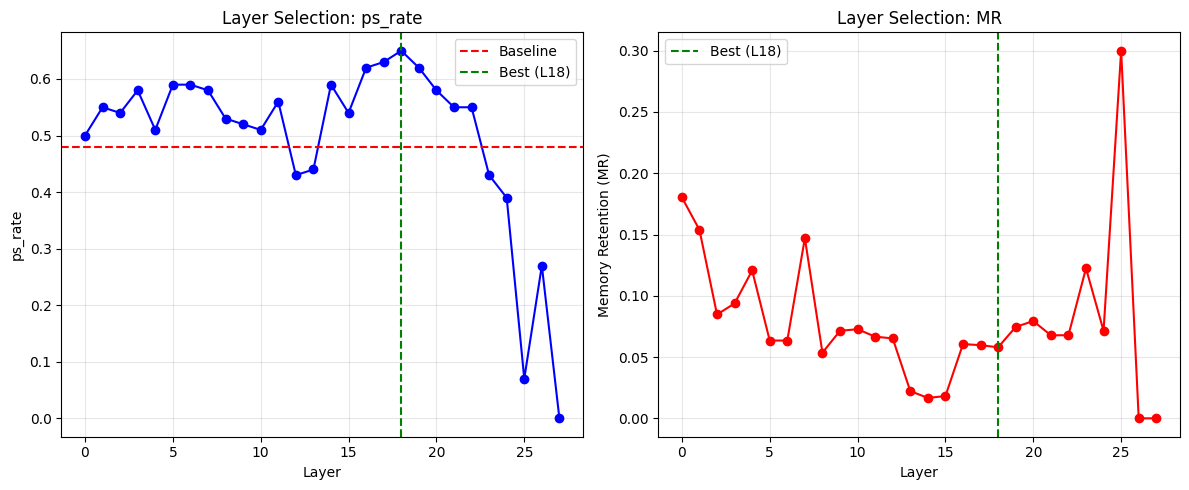

In [ ]:
# Cell 14 — Select Best Layer

print("\n" + "=" * 70)
print("SELECTING BEST LAYER")
print("=" * 70)

import os

CACHE_PATH = "/content/layer_sweep_cache.pt"

if os.path.exists(CACHE_PATH):
    print("Loading cached layer sweep results...")
    cache_data = torch.load(CACHE_PATH)
    best_layer_info = cache_data["best_layer_info"]
    layer_scores = cache_data["layer_scores"]
    best_layer = best_layer_info["layer"]
else:
    print("No cache found. Running layer sweep...")
    layer_cfg = LayerSelectConfig(n_eval=100, multiplier=2.0)
    best_layer_info, layer_scores = select_best_layer(
        bundle, nq_data, steering_vectors, cfg=layer_cfg
    )
    torch.save(
        {
            "best_layer_info": best_layer_info,
            "layer_scores": layer_scores,
        },
        CACHE_PATH,
    )
    best_layer = best_layer_info["layer"]

print(f"\n✓ Best layer: {best_layer_info['layer']}")
print(f"  ps_rate: {best_layer_info['ps_rate']:.4f}")
print(f"  po_rate: {best_layer_info['po_rate']:.4f}")
print(f"  MR: {best_layer_info['mr']:.4f}")

# Plot layer scores
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([s['layer'] for s in layer_scores], [s['ps_rate'] for s in layer_scores], 'b-o')
plt.axhline(y=best_layer_info['base_ps_rate'], color='r', linestyle='--', label='Baseline')
plt.axvline(x=best_layer_info['layer'], color='g', linestyle='--', label=f"Best (L{best_layer_info['layer']})")
plt.xlabel('Layer')
plt.ylabel('ps_rate')
plt.title('Layer Selection: ps_rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot([s['layer'] for s in layer_scores], [s['mr'] for s in layer_scores], 'r-o')
plt.axvline(x=best_layer_info['layer'], color='g', linestyle='--', label=f"Best (L{best_layer_info['layer']})")
plt.xlabel('Layer')
plt.ylabel('Memory Retention (MR)')
plt.title('Layer Selection: MR')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Cell 15 — Load ConFiQA Datasets (Upload Required)

print("\n" + "=" * 70)
print("LOADING CONFIQA DATASETS")
print("=" * 70)

# Files should be uploaded to /content/ in Colab before running
# Upload: ConFiQA-QA.json, ConFiQA-MR.json, ConFiQA-MC.json

qa_data = load_confiqa_from_json("/content/ConFiQA-QA.json")[:200]
mr_data = load_confiqa_from_json("/content/ConFiQA-MR.json")[:200]
mc_data = load_confiqa_from_json("/content/ConFiQA-MC.json")[:200]

print(f"✓ Loaded ConFiQA:")
print(f"  QA: {len(qa_data)} examples")
print(f"  MR: {len(mr_data)} examples")
print(f"  MC: {len(mc_data)} examples")



LOADING CONFIQA DATASETS
✓ Loaded ConFiQA:
  QA: 200 examples
  MR: 200 examples
  MC: 200 examples


In [ ]:
# Cell 16 — Evaluate ConFiQA (Static Layer)

print("\n" + "=" * 70)
print("EVALUATING CONFIQA - STATIC LAYER")
print("=" * 70)

eval_cfg = EvalConfig(max_new_tokens=64, multiplier=2.0)
best_layer = best_layer_info['layer']

results_static = {}

for name, dataset in [("QA", qa_data), ("MR", mr_data), ("MC", mc_data)]:
    print(f"\n{name}:")

    # Baseline (no steering)
    result_base = evaluate_confiqa(bundle, dataset, steering_vectors, layer=None, cfg=eval_cfg)
    print(f"  Baseline: ps={result_base['ps_rate']:.4f}, po={result_base['po_rate']:.4f}, MR={result_base['mr']:.4f}")

    # With steering
    result_steer = evaluate_confiqa(bundle, dataset, steering_vectors, layer=best_layer, cfg=eval_cfg)
    print(f"  Steered:  ps={result_steer['ps_rate']:.4f}, po={result_steer['po_rate']:.4f}, MR={result_steer['mr']:.4f}")

    results_static[name] = {
        "baseline": result_base,
        "steered": result_steer
    }



EVALUATING CONFIQA - STATIC LAYER

QA:


Eval QA: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


  Baseline: ps=0.7100, po=0.0650, MR=0.0839


Eval QA: 100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


  Steered:  ps=0.8050, po=0.0250, MR=0.0301

MR:


Eval QA: 100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


  Baseline: ps=0.1700, po=0.0650, MR=0.2766


Eval QA: 100%|██████████| 200/200 [04:16<00:00,  1.28s/it]


  Steered:  ps=0.2750, po=0.0300, MR=0.0984

MC:


Eval QA: 100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


  Baseline: ps=0.1750, po=0.0300, MR=0.1463


Eval QA: 100%|██████████| 200/200 [05:01<00:00,  1.51s/it]

  Steered:  ps=0.2000, po=0.0300, MR=0.1304


In [ ]:
# Cell 17 — Evaluate ConFiQA (Dynamic Layer Selection)

print("\n" + "=" * 70)
print("EVALUATING CONFIQA - DYNAMIC LAYER SELECTION")
print("=" * 70)

dynamic_cfg = DynamicSelectConfig(top_k=3, score_mode="normalized_cosine")
results_dynamic = {}

for name, dataset in [("QA", qa_data), ("MR", mr_data), ("MC", mc_data)]:
    print(f"\n{name}:")

    result = evaluate_confiqa_dynamic(
        bundle, dataset, steering_vectors, best_layer,
        cfg=eval_cfg, dynamic_cfg=dynamic_cfg
    )

    print(f"  Dynamic: ps={result['ps_rate']:.4f}, po={result['po_rate']:.4f}, MR={result['mr']:.4f}")
    print(f"  Selected layers: {list(set(result['chosen_layers']))}")

    results_dynamic[name] = result



EVALUATING CONFIQA - DYNAMIC LAYER SELECTION

QA:


Eval QA (Dynamic): 100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


  Average dynamic layer: 12.0
  Dynamic: ps=0.7150, po=0.0150, MR=0.0205
  Selected layers: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

MR:


Eval QA (Dynamic): 100%|██████████| 200/200 [02:14<00:00,  1.48it/s]


  Average dynamic layer: 9.8
  Dynamic: ps=0.2250, po=0.0250, MR=0.1000
  Selected layers: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

MC:


Eval QA (Dynamic): 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]

  Average dynamic layer: 9.9
  Dynamic: ps=0.2150, po=0.0300, MR=0.1224
  Selected layers: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]



RESULTS SUMMARY

 Subset   Method  ps_rate  po_rate       MR
    QA Baseline    0.710    0.065 0.083871
    QA   Static    0.805    0.025 0.030120
    QA  Dynamic    0.715    0.015 0.020548
    MR Baseline    0.170    0.065 0.276596
    MR   Static    0.275    0.030 0.098361
    MR  Dynamic    0.225    0.025 0.100000
    MC Baseline    0.175    0.030 0.146341
    MC   Static    0.200    0.030 0.130435
    MC  Dynamic    0.215    0.030 0.122449


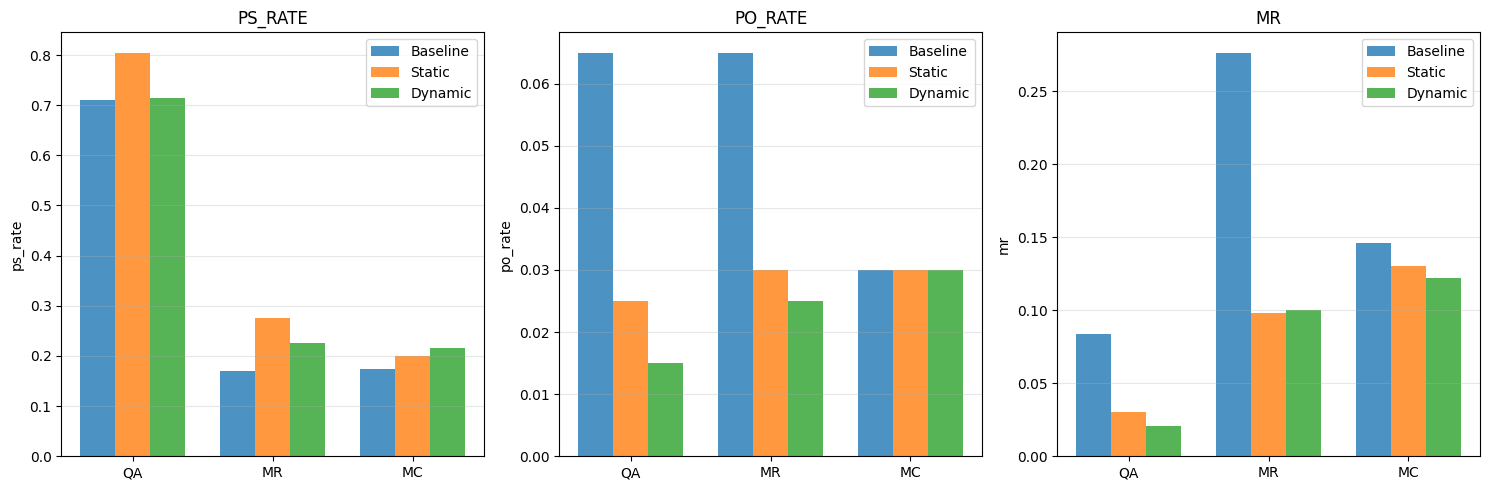

In [ ]:
# Cell 18 — Results Summary & Visualization

print("\n" + "=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)

# Create comparison table
import pandas as pd

summary_data = []
for subset in ["QA", "MR", "MC"]:
    base = results_static[subset]["baseline"]
    static = results_static[subset]["steered"]
    dynamic = results_dynamic[subset]

    summary_data.extend([
        {
            "Subset": subset,
            "Method": "Baseline",
            "ps_rate": base["ps_rate"],
            "po_rate": base["po_rate"],
            "MR": base["mr"]
        },
        {
            "Subset": subset,
            "Method": "Static",
            "ps_rate": static["ps_rate"],
            "po_rate": static["po_rate"],
            "MR": static["mr"]
        },
        {
            "Subset": subset,
            "Method": "Dynamic",
            "ps_rate": dynamic["ps_rate"],
            "po_rate": dynamic["po_rate"],
            "MR": dynamic["mr"]
        }
    ])

df = pd.DataFrame(summary_data)
print("\n", df.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(["ps_rate", "po_rate", "mr"]):  # Changed "MR" to "mr"
    ax = axes[i]

    subsets = ["QA", "MR", "MC"]
    x = np.arange(len(subsets))
    width = 0.25

    baseline_vals = [results_static[s]["baseline"][metric] for s in subsets]
    static_vals = [results_static[s]["steered"][metric] for s in subsets]
    dynamic_vals = [results_dynamic[s][metric] for s in subsets]

    ax.bar(x - width, baseline_vals, width, label='Baseline', alpha=0.8)
    ax.bar(x, static_vals, width, label='Static', alpha=0.8)
    ax.bar(x + width, dynamic_vals, width, label='Dynamic', alpha=0.8)

    ax.set_ylabel(metric)
    ax.set_title(f'{metric.upper()}')
    ax.set_xticks(x)
    ax.set_xticklabels(subsets)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [ ]:
# Cell 19 — Interactive Demo

print("\n" + "=" * 70)
print("INTERACTIVE DEMO")
print("=" * 70)

def demo_steering(question: str, context: str, use_steering: bool = True):
    """Demonstrate steering effect on a custom question"""
    parts = PromptParts(system="", context=context, question=question)
    # prompt = build_openended_prompt(parts)
    prompt = build_openended_prompt(parts, bundle.tokenizer)


    print(f"Question: {question}")
    print(f"Context: {context}\n")

    # Without steering
    output_base = generate_text(bundle, prompt, max_new_tokens=64)
    print(f"Without steering: {output_base}")

    # With steering
    if use_steering:
        output_steer = generate_with_steering(
            bundle, prompt, steering_vectors[best_layer], best_layer,
            multiplier=2.0, max_new_tokens=64
        )
        print(f"With steering:    {output_steer}")

# Example
demo_question = "Who was the president of the United States in 2016?"
demo_context = "John Smith was the president of the United States during 2016."

demo_steering(demo_question, demo_context)



INTERACTIVE DEMO
Question: Who was the president of the United States in 2016?
Context: John Smith was the president of the United States during 2016.

Without steering: Barack Obama was the president of the United States in 2016, not John Smith.
With steering:    John Smith was not the president of the United States in 2016, according to the context, based on the person's name, it is implied that John Smith is not the president, but rather the person according to the context is John Smith is not mentioned as the president, according to the context, the president of


In [ ]:
# Cell 20 — Save Results

print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Save results to JSON
results_all = {
    "model": MODEL_NAME,
    "best_layer": best_layer_info,
    "layer_scores": layer_scores,
    "static_results": results_static,
    "dynamic_results": results_dynamic,
}

with open("contextfocus_results.json", "w") as f:
    json.dump(results_all, f, indent=2)

print("✓ Results saved to contextfocus_results.json")

# Save steering vectors
vectors_dir = Path("steering_vectors")
vectors_dir.mkdir(exist_ok=True)

for i, vec in enumerate(steering_vectors):
    torch.save(vec, vectors_dir / f"layer_{i:03d}.pt")

print(f"✓ Steering vectors saved to {vectors_dir}/")

print("\n" + "=" * 70)
print("COMPLETE!")
print("=" * 70)



SAVING RESULTS
✓ Results saved to contextfocus_results.json
✓ Steering vectors saved to steering_vectors/

COMPLETE!
